### 采用时间序列干预模型分析法分析利好对股票价格的影响
<p>利好消息作为一个干预事件通常会对股票分析造成很重要的影响。我们初次的分析，主要将利好抽象化，以指数的形式进行，后面可以将利好拆解开来。分别考虑。</p>

In [1]:
import requests
import json
import numpy as np
from pandas import Series, DataFrame 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [2]:
#内置图像
%matplotlib inline
%config InlineBackend.figure_format="svg" 
%load_ext rpy2.ipython

# 1.对数据进行基本的统计分析

In [7]:
#获取股票数据的接口
feeling_url = "http://localhost:4444/api/feelings/375"
trade_url = "http://localhost:4444/api/trades/375"

In [8]:
#定义一个请求数据的函数
def getData(url):
    r = requests.get(url)
    return json.loads(r.text)
#查询数据获得收盘价
def findFeeling(time,list):
    for l in list:
        if l['time'] == time:
            return l['feelingIndex']
#获取数组的移动平均转换
def moveAverage(list,n):
    new =[0]*len(list)
    l = np.array(list)
    for i in xrange(n-1,len(list)):
        new[i]=l[i-n+1:i].mean()
    return new
#获取滞后几日的收益率
def dayRate(list,n):
    new =[0]*len(list)
    for i in xrange(0,len(list)-n):
        new[i] = (list[i+n]-list[i])/list[i]
    return new

In [9]:
#获取股票的数据
feeling_list = getData(feeling_url)
trade_list = getData(trade_url)

In [10]:
#定义三个时间序列
times = []
feelings = []
closePrices = []
#遍历原始数据，生成三个时间序列

for trade in trade_list:
    time = trade['time']
    times.append(time)
    closePrices.append(trade['closePrice'])
    #查找这个时间的利好条数和位置
    f = findFeeling(time,feeling_list)
    feelings.append(f)
feeling_7ma = moveAverage(feelings,3)
Rate_3day = dayRate(closePrices,3)
Rate_7day = dayRate(closePrices,7)
Rate_10day = dayRate(closePrices,10)
Rate_20day = dayRate(closePrices,20)

In [11]:
#构建pandas数组
data = {'time': times[9:],
        'feeling': feelings[9:],
        'closePrice': closePrices[9:],
        'feeling_7ma':feeling_7ma[9:],
        'Rate_3day': Rate_3day[9:],      
        'Rate_7day': Rate_7day[9:],
        'Rate_10day': Rate_10day[9:],
        'Rate_20day': Rate_20day[9:],
       }
frame = DataFrame(data)
#将time作为索引
stockInfo = frame.set_index('time')

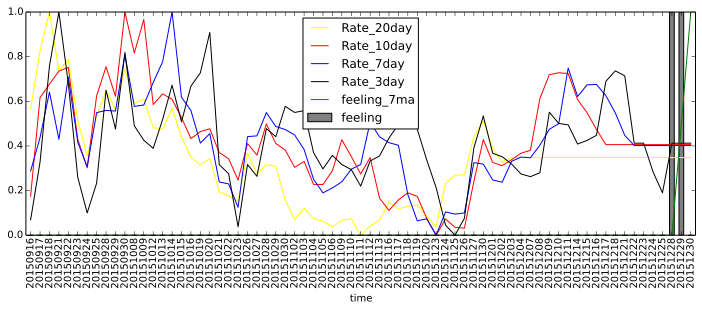

In [12]:
#将这两个数据放置到图片上
#将两列数据进行标准化并作图
# stockInfo.Rate_7day.plot(color='red',figsize=(12,8))
# stockInfo.feeling_7ma.plot(color='green')
# stockInfo.feeling.plot(color='gray',kind='bar')
# plt.legend(loc='best')
stockInfo_stand = stockInfo.apply(lambda x:(x-np.min(x))/(np.max(x)-np.min(x)))
stockInfo_stand.Rate_20day.plot(color='yellow',figsize=(12,4))
stockInfo_stand.Rate_10day.plot(color='red',figsize=(12,4))
stockInfo_stand.Rate_7day.plot(color='blue',figsize=(12,4))
stockInfo_stand.Rate_3day.plot(color='black',figsize=(12,4))
stockInfo_stand.feeling_7ma.plot(color='green')
stockInfo_stand.feeling.plot(color='gray',kind='bar')
plt.legend(loc='best')

# 2.对股票数据分析适用ARIMA模型

In [14]:
%%R
library(TSA)

In [15]:
#将时间序列数据形成numPy对象
dta = np.array(closePrices)

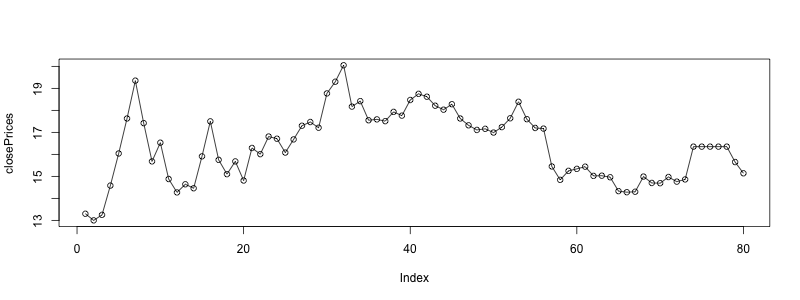

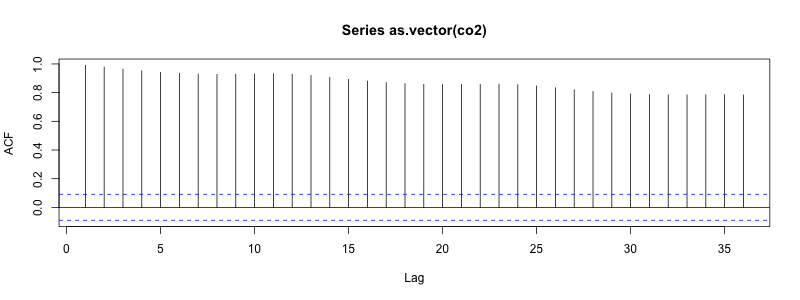

In [16]:
%%R -i dta -w 800 -h 300
#画图并观察自相关函数
plot(dta,ylab='closePrices',type='o')
acf(as.vector(co2),lag.max=36)

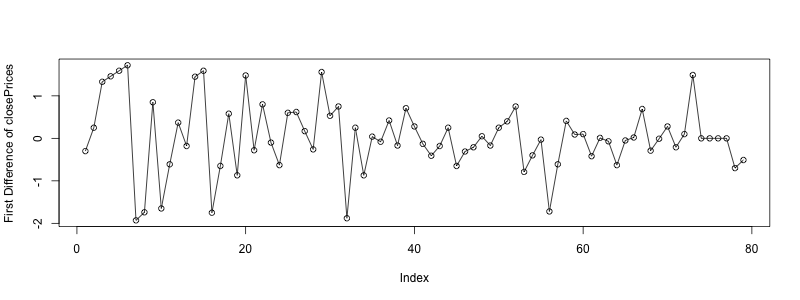

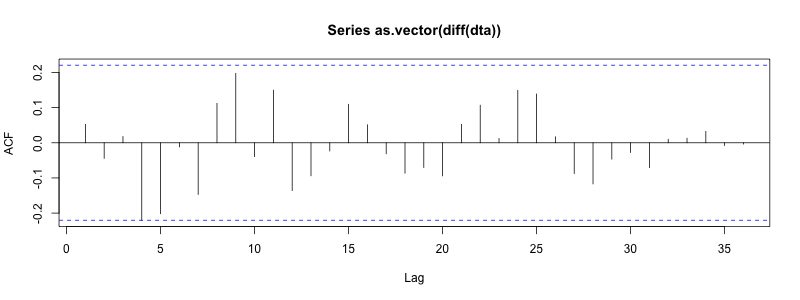

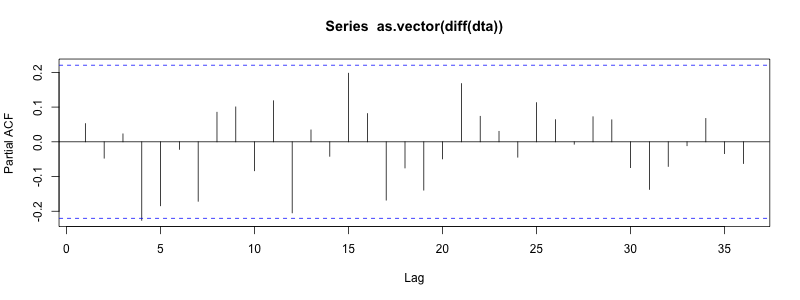

In [17]:
%%R -i dta -w 800 -h 300
#观察一阶差分
plot(diff(dta),ylab='First Difference of closePrices',type='o')
acf(as.vector(diff(dta)),lag.max=36)
pacf(as.vector(diff(dta)),lag.max=36)

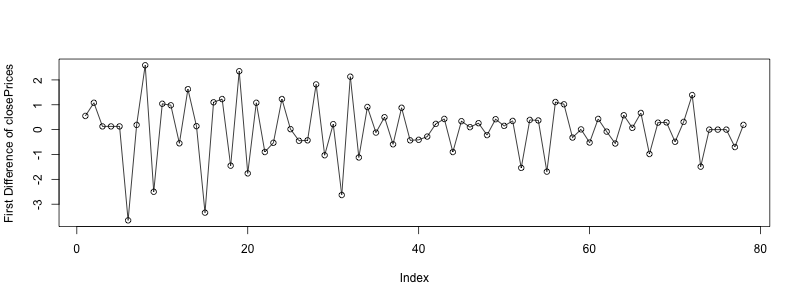

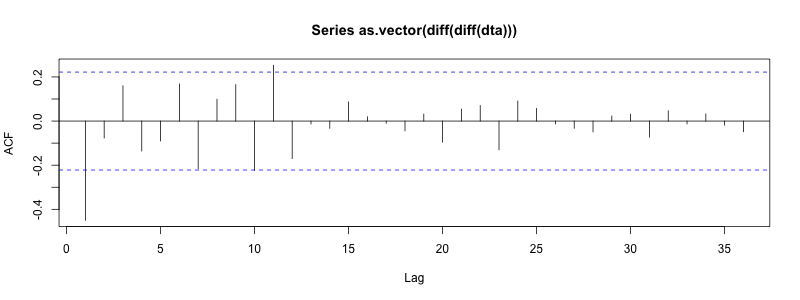

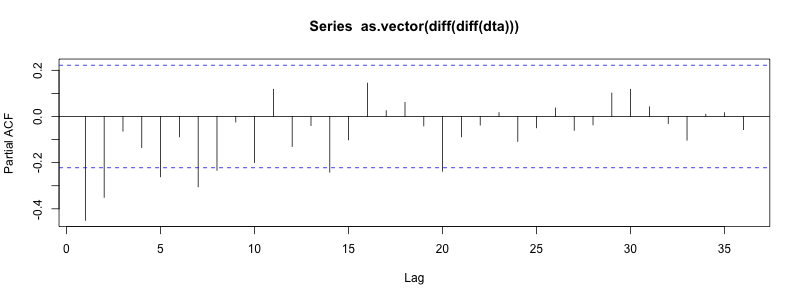

In [18]:
%%R -i dta -w 800 -h 300
#观察二阶差分
plot(diff(diff(dta)),ylab='First Difference of closePrices',type='o')
acf(as.vector(diff(diff(dta))),lag.max=36)
pacf(as.vector(diff(diff(dta))),lag.max=36)

从上图可以看出二阶差分基本上比较平稳，选取二阶差分数据进行建模，根据ACF和PACF判断应该建立ARIMA(6,1,0)模型

In [29]:
%%R -i dta
#建立ARIMA(5，2，1)模型
m1.dta = arima(dta,order=c(7,2,1))
m1.dta


Call:
arima(x = dta, order = c(7, 2, 1))

Coefficients:
          ar1      ar2      ar3      ar4      ar5      ar6      ar7      ma1
      -0.0798  -0.1670  -0.0879  -0.2790  -0.3025  -0.1602  -0.2835  -0.9011
s.e.   0.1648   0.1555   0.1419   0.1263   0.1494   0.1664   0.1527   0.1623

sigma^2 estimated as 0.5722:  log likelihood = -91.11,  aic = 198.22


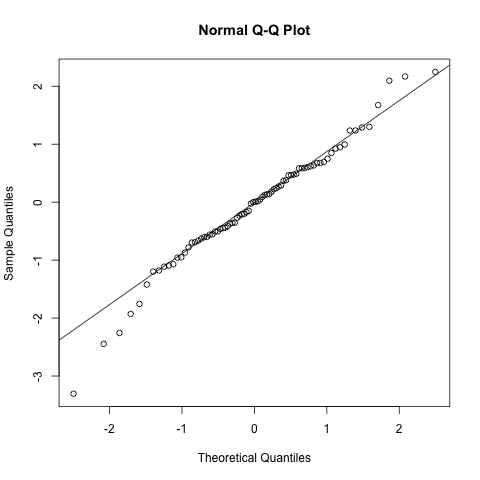

In [30]:
%%R
#QQ图
qqnorm(window(rstandard(m1.dta),start=1))
qqline(window(rstandard(m1.dta),start = 1))

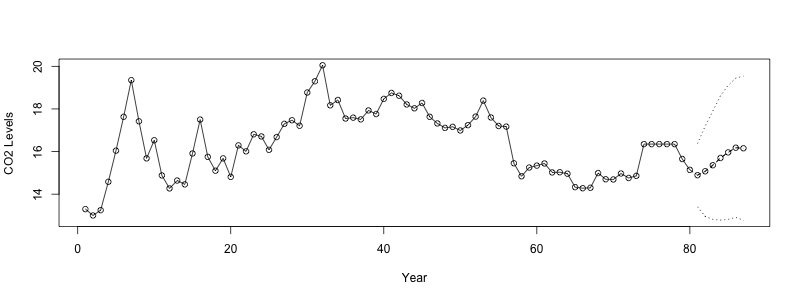

In [31]:
%%R -w 800 -h 300
plot(m1.dta,n.ahead=7,xlab='Year',type='o',ylab='CO2 Levels')

# 3.建立干预模型